[![Lab Documentation and Solutions](https://img.shields.io/badge/Lab%20Documentation%20and%20Solutions-purple)](https://mongodb-developer.github.io/ai-agents-lab/)


# Step 1: Setup prerequisites

In [217]:
import os
import sys
from pymongo import MongoClient

# Add parent directory to path to import from utils
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))
from utils import track_progress, set_env

In [218]:
# If you are using your own MongoDB Atlas cluster, use the connection string for your cluster here
MONGODB_URI = os.environ.get("MONGODB_URI")
# Initialize a MongoDB Python client
mongodb_client = MongoClient(MONGODB_URI)
# Check the connection to the server
mongodb_client.admin.command("ping")

{'ok': 1.0,
 '$clusterTime': {'clusterTime': Timestamp(1765505672, 1),
  'signature': {'hash': b'Z\xd5\x85q\xeev\xab6\xae1\xe4\xad\xd0M\xd8\xb0\x984\xde\x9e',
   'keyId': 7581688592607477766}},
 'operationTime': Timestamp(1765505672, 1)}

In [219]:
# Track progress of key steps-- DO NOT CHANGE
track_progress("cluster_creation", "ai_agents_lab")

Tracking progress for task cluster_creation


In [ ]:
# Set the LLM provider and passkey provided by your workshop instructor
# NOTE: LLM_PROVIDER can be set to one of "aws"/ "microsoft" / "google"
LLM_PROVIDER = "aws"
PASSKEY = ""

In [221]:
# Obtain API keys from our AI model proxy and set them as environment variables-- DO NOT CHANGE
set_env([LLM_PROVIDER,"voyageai"], PASSKEY)

Successfully set AWS_ACCESS_KEY_ID environment variable.
Successfully set AWS_SECRET_ACCESS_KEY environment variable.
Successfully set VOYAGE_API_KEY environment variable.


# Step 2: Import data into MongoDB

In [222]:
import json

### **Do not change the values assigned to the variables below**

In [223]:
#  Database name
DB_NAME = "mongodb_genai_devday_agents"
# Name of the collection with full documents- used for summarization
FULL_COLLECTION_NAME = "mongodb_docs"
# Name of the collection for vector search- used for Q&A
VS_COLLECTION_NAME = "mongodb_docs_embeddings"
# Name of the vector search index
VS_INDEX_NAME = "vector_index"

In [224]:
# Connect to the `VS_COLLECTION_NAME` collection.
vs_collection = mongodb_client[DB_NAME][VS_COLLECTION_NAME]
# Connect to the `FULL_COLLECTION_NAME` collection.
full_collection = mongodb_client[DB_NAME][FULL_COLLECTION_NAME]

In [225]:
# Insert a dataset of MongoDB docs with embeddings into the `VS_COLLECTION_NAME` collection
with open(f"../data/{VS_COLLECTION_NAME}.json", "r") as data_file:
    json_data = data_file.read()

data = json.loads(json_data)

print(f"Deleting existing documents from the {VS_COLLECTION_NAME} collection.")
vs_collection.delete_many({})
vs_collection.insert_many(data)
print(
    f"{vs_collection.count_documents({})} documents ingested into the {VS_COLLECTION_NAME} collection."
)

Deleting existing documents from the mongodb_docs_embeddings collection.
101 documents ingested into the mongodb_docs_embeddings collection.


In [226]:
# Insert a dataset of MongoDB documentation pages into the `FULL_COLLECTION_NAME` collection
with open(f"../data/{FULL_COLLECTION_NAME}.json", "r") as data_file:
    json_data = data_file.read()

data = json.loads(json_data)

print(f"Deleting existing documents from the {FULL_COLLECTION_NAME} collection.")
full_collection.delete_many({})
full_collection.insert_many(data)
print(
    f"{full_collection.count_documents({})} documents ingested into the {FULL_COLLECTION_NAME} collection."
)

Deleting existing documents from the mongodb_docs collection.
20 documents ingested into the mongodb_docs collection.


# Step 3: Create a vector search index

In [227]:
from utils import create_index, check_index_ready

In [228]:
# Create vector index definition specifying:
# path: Path to the embeddings field
# numDimensions: Number of embedding dimensions- depends on the embedding model used
# similarity: Similarity metric. One of cosine, euclidean, dotProduct.
model = {
    "name": VS_INDEX_NAME,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 1024,
                "similarity": "cosine",
            }
        ]
    },
}

In [229]:
# Use the `create_index` function from the `utils` module to create a vector search index with the above definition for the `vs_collection` collection
create_index(vs_collection, VS_INDEX_NAME, model)

Creating the vector_index index


In [230]:
# Use the `check_index_ready` function from the `utils` module to verify that the index was created and is in READY status before proceeding
check_index_ready(vs_collection, VS_INDEX_NAME)

vector_index index status: READY
vector_index index definition: {'fields': [{'type': 'vector', 'path': 'embedding', 'numDimensions': 1024, 'similarity': 'cosine'}]}


In [231]:
# Track progress of key steps-- DO NOT CHANGE
track_progress("vs_index_creation", "ai_agents_lab")

Tracking progress for task vs_index_creation


# Step 4: Create agent tools


In [232]:
from langchain.tools import tool
import voyageai
from typing import List

### Vector Search

In [233]:
# Initialize the Voyage AI client
vo = voyageai.Client()

📚 https://docs.voyageai.com/docs/contextualized-chunk-embeddings#approach-2-contextualized-chunk-embeddings

In [234]:
def get_embeddings(query: str) -> List[float]:
    """
    Get embeddings for an input query.

    Args:
        query (str): Query string

    Returns:
        List[float]: Embedding of the query string
    """
    # Use the `contextualized_embed` method of the Voyage AI API to embed the user query with the following arguments:
    # inputs: `query` wrapped in a list of lists
    # model: `voyage-context-3`
    # input_type: "query"
    embds_obj = vo.contextualized_embed(inputs=[[query]], model="voyage-context-3", input_type="query")
    # Extract embeddings from the embeddings object
    embeddings = embds_obj.results[0].embeddings[0]
    return embeddings

📚 https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-stage/#ann-examples (Refer to the "Basic Example")

In [235]:
# Define a tool to retrieve relevant documents for a user query using vector search
@tool
def get_information_for_question_answering(user_query: str) -> str:
    """
    Retrieve information using vector search to answer a user query.

    Args:
    user_query (str): The user's query string.

    Returns:
    str: The retrieved information formatted as a string.
    """

    # Generate embeddings for the `user_query` using the `get_embeddings` function defined above
    query_embedding = get_embeddings(user_query)

    # Define an aggregation pipeline consisting of a $vectorSearch stage, followed by a $project stage
    # Set the number of candidates to 150 and only return the top 5 documents from the vector search
    # In the $project stage, exclude the `_id` field and include only the `body` field and `vectorSearchScore`
    # NOTE: Use variables defined previously for the `index`, `queryVector` and `path` fields in the $vectorSearch stage
    pipeline = [
        {
            "$vectorSearch": {
                "index": VS_INDEX_NAME,
                "path": "embedding",
                "queryVector": query_embedding,
                "numCandidates": 150,
                "limit": 5,
            }
        },
        {
            "$project": {
                "_id": 0,
                "body": 1,
                "score": {"$meta": "vectorSearchScore"},
            }
        },
    ]

    # Execute the aggregation `pipeline` against the `vs_collection` collection and store the results in `results`
    results = vs_collection.aggregate(pipeline)
    # Concatenate the results into a string
    context = "\n\n".join([doc.get("body") for doc in results])
    return context

### Get page content

📚 https://www.mongodb.com/docs/manual/reference/method/db.collection.findOne/#return-all-but-the-excluded-fields

In [236]:
# Define a tool to retrieve the content of a documentation page for summarization
@tool
def get_page_content_for_summarization(user_query: str) -> str:
    """
    Retrieve page content based on provided title.

    Args:
    user_query (str): The user's query string i.e. title of the documentation page.

    Returns:
    str: The content of the page.
    """
    # Query the documents where the `title` field is equal to the `user_query`
    query = {"title": user_query}
    # Only return the `body` field from the retrieved documents.
    # NOTE: Set fields to include to 1, those to exclude to 0. `_id` is included by default, so exclude that.
    projection = {"_id": 0, "body": 1}
    # Use the `query` and `projection` with the `find_one` method
    # to get the `body` of the document with `title` equal to the `user_query` from the `full_collection` collection
    document = full_collection.find_one(query, projection)
    if document:
        return document["body"]
    else:
        return "Document not found"

In [237]:
# Create the list of tools
tools = [
    get_information_for_question_answering,
    get_page_content_for_summarization,
]

### Test out the tools


In [238]:
# Test out the `get_information_for_question_answering` tool with the query "What are some best practices for data backups in MongoDB?"
# You should see a non-empty response
get_information_for_question_answering.invoke(
    "What are some best practices for data backups in MongoDB?"
)

''

In [239]:
# Test out the `get_page_content_for_summarization` tool with page title "Create a MongoDB Deployment"
# You should see a non-empty response
get_page_content_for_summarization.invoke("Create a MongoDB Deployment")

"# Create a MongoDB Deployment\n\nYou can create a free tier MongoDB deployment on MongoDB Atlas to store and manage your data. MongoDB Atlas hosts and manages your MongoDB database in the cloud.\n\n## Create a Free MongoDB deployment on Atlas\n\nComplete the Get Started with Atlas guide to set up a new Atlas account and load sample data into a new free tier MongoDB deployment.\n\n## Save your Credentials\n\nAfter you create your database user, save that user's username and password to a safe location for use in an upcoming step.\n\nAfter you complete these steps, you have a new free tier MongoDB deployment on Atlas, database user credentials, and sample data loaded in your database.\n\nIf you run into issues on this step, ask for help in the MongoDB Community Forums or submit feedback by using the Rate this page tab on the right or bottom right side of this page.\n\n"

# Step 5: Define graph state

In [240]:
from typing import Annotated
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

In [241]:
# Define the graph state
# We are only tracking chat messages but you can track other attributes as well
class GraphState(TypedDict):
    messages: Annotated[list, add_messages]

# Step 6: Instantiate the LLM

In [242]:
from langchain_core.load import load
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from utils import get_llm

In [243]:
# Obtain the Langchain LLM object using the `get_llm` function from the `utils`` module.
llm = get_llm(LLM_PROVIDER)

In [244]:
# Create a Chain-of-Thought (CoT) prompt template for the agent.
# This includes a system prompt with a placeholder for tool names, and a placeholder for messages i.e. user queries and assistant responses
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "You are a helpful AI assistant."
            " You are provided with tools to answer questions and summarize technical documentation related to MongoDB."
            " Think step-by-step and use these tools to get the information required to answer the user query."
            " Do not re-run tools unless absolutely necessary."
            " If you are not able to get enough information using the tools, reply with I DON'T KNOW."
            " You have access to the following tools: {tool_names}."
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [245]:
# Fill in the prompt template with the tool names
prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))

📚 https://python.langchain.com/v0.1/docs/modules/model_io/chat/function_calling/#binding-tool-schemas

In [246]:
# Bind the `tools` to the `llm` instantiated above
bind_tools = llm.bind_tools(tools)

📚 https://python.langchain.com/v0.1/docs/expression_language/primitives/sequence/#the-pipe-operator

In [247]:
# Chain the `prompt` with the tool-augmented llm using the `|` operator
llm_with_tools = prompt | bind_tools

In [248]:
# Test that the LLM is making the right tool calls
llm_with_tools.invoke(
    ["Give me a summary of the page titled Create a MongoDB Deployment."]
).tool_calls

[{'name': 'get_page_content_for_summarization',
  'args': {'user_query': 'Create a MongoDB Deployment'},
  'id': 'toolu_bdrk_01XhgNo3r32nfFZCJ2fHk2pf',
  'type': 'tool_call'}]

In [249]:
# Test that the LLM is making the right tool calls
llm_with_tools.invoke(
    ["What are some best practices for data backups in MongoDB?"]
).tool_calls

[{'name': 'get_information_for_question_answering',
  'args': {'user_query': 'best practices for data backups in MongoDB'},
  'id': 'toolu_bdrk_01WW7q49BzYEYWbSjP6zRvLv',
  'type': 'tool_call'}]

# Step 7: Define graph nodes

In [250]:
from langchain_core.messages import ToolMessage
from typing import Dict
from pprint import pprint

In [251]:
# Define the agent node
def agent(state: GraphState) -> Dict[str, List]:
    """
    Agent node

    Args:
        state (GraphState): Graph state

    Returns:
        Dict[str, List]: Updates to messages
    """
    # Get the messages from the graph `state`
    messages = state["messages"]
    # Invoke `llm_with_tools` with `messages` using the `invoke` method
    # HINT: See Step 6 for how to invoke `llm_with_tools`
    result = llm_with_tools.invoke(messages)
    # Write `result` to the `messages` attribute of the graph state
    return {"messages": [result]}

In [252]:
# Create a map of tool name to tool call
tools_by_name = {tool.name: tool for tool in tools}
pprint(tools_by_name)

{'get_information_for_question_answering': StructuredTool(name='get_information_for_question_answering', description="Retrieve information using vector search to answer a user query.\n\nArgs:\nuser_query (str): The user's query string.\n\nReturns:\nstr: The retrieved information formatted as a string.", args_schema=<class 'langchain_core.utils.pydantic.get_information_for_question_answering'>, func=<function get_information_for_question_answering at 0x7845bb9fef20>),
 'get_page_content_for_summarization': StructuredTool(name='get_page_content_for_summarization', description="Retrieve page content based on provided title.\n\nArgs:\nuser_query (str): The user's query string i.e. title of the documentation page.\n\nReturns:\nstr: The content of the page.", args_schema=<class 'langchain_core.utils.pydantic.get_page_content_for_summarization'>, func=<function get_page_content_for_summarization at 0x7845da75a660>)}


In [253]:
# Define tool node
def tool_node(state: GraphState) -> Dict[str, List]:
    """
    Tool node

    Args:
        state (GraphState): Graph state

    Returns:
        Dict[str, List]: Updates to messages
    """
    result = []
    # Get the list of tool calls from messages
    tool_calls = state["messages"][-1].tool_calls
    # A tool_call looks as follows:
    # {
    #     "name": "get_information_for_question_answering",
    #     "args": {"user_query": "What are Atlas Triggers"},
    #     "id": "call_H5TttXb423JfoulF1qVfPN3m",
    #     "type": "tool_call",
    # }
    # Iterate through `tool_calls`
    for tool_call in tool_calls:
        # Get the tool from `tools_by_name` using the `name` attribute of the `tool_call`
        tool = tools_by_name[tool_call["name"]]
        # Invoke the `tool` using the `args` attribute of the `tool_call`
        # HINT: See previous line to see how to extract attributes from `tool_call`
        observation = tool.invoke(tool_call["args"])
        # Append the result of executing the tool to the `result` list as a ToolMessage
        # The `content` of the message is `observation` i.e. result of the tool call
        # The `tool_call_id` can be obtained from the `tool_call`
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    # Write `result` to the `messages` attribute of the graph state
    return {"messages": result}

# Step 8: Define conditional edges

In [254]:
from langgraph.graph import END

In [255]:
# Define conditional routing function
def route_tools(state: GraphState):
    """
    Use in the conditional_edge to route to the tool node if the last message
    has tool calls. Otherwise, route to the end.
    """
    # Get messages from graph state
    messages = state.get("messages", [])
    if len(messages) > 0:
        # Get the last AI message from messages
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    # Check if the last message has tool calls
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # If yes, return "tools"
        return "tools"
    # If no, return END
    return END

# Step 9: Build the graph

In [256]:
from langgraph.graph import StateGraph, START
from IPython.display import Image, display

In [257]:
# Instantiate the graph
graph = StateGraph(GraphState)

📚 https://blog.langchain.dev/langgraph/#nodes

In [258]:
# Add nodes to the `graph` using the `add_node` function
# Add a `agent` node. The `agent` node should run the `agent` function
graph.add_node("agent", agent)
# Add a `tools` node. The `tools` node should run the `tool_node` function
graph.add_node("tools", tool_node)

📚 https://langchain-ai.github.io/langgraph/concepts/low_level/#normal-edges

In [259]:
# Add fixed edges to the `graph` using the `add_edge` method
# Add an edge from the START node to the `agent` node
graph.add_edge(START, "agent")
# Add an edge from the `tools` node to the `agent` node
graph.add_edge("tools", "agent")

📚 https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges

In [260]:
# Use the `add_conditional_edges` method to add a conditional edge from the `agent` node to the `tools` node
# based on the output of the `route_tools` function
graph.add_conditional_edges(
    "agent",
    route_tools,
    {"tools": "tools", END: END},
)

In [261]:
# Compile the `graph`
app = graph.compile()

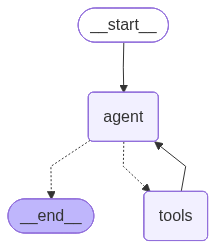

In [262]:
# Visualize the graph
app

# Step 10: Execute the graph

In [263]:
def execute_graph(user_input: str) -> None:
    """
    Stream outputs from the graph

    Args:
        user_input (str): User query string
    """
    # Stream outputs from each step in the graph
    for step in app.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        # Stream full value of the state after each step
        stream_mode="values",
    ):
        # Print the latest message from the step
        step["messages"][-1].pretty_print()

In [264]:
# Test the graph execution to view end-to-end flow
execute_graph("What are some best practices for data backups in MongoDB?")

================================ Human Message =================================

What are some best practices for data backups in MongoDB?
================================== Ai Message ==================================

I'll help you find information about best practices for data backups in MongoDB.
Tool Calls:
  get_information_for_question_answering (toolu_bdrk_01Rdj3rSDehUxGyEpdEiM8W1)
 Call ID: toolu_bdrk_01Rdj3rSDehUxGyEpdEiM8W1
  Args:
    user_query: best practices for data backups in MongoDB
================================= Tool Message =================================

# Backup and Restore Sharded Clusters

The following tutorials describe backup and restoration for sharded clusters:

To use `mongodump` and `mongorestore` as a backup strategy for sharded clusters, you must stop the sharded cluster balancer and use the `fsync` command or the `db.fsyncLock()` method on `mongos` to block writes on the cluster during backups.

Sharded clusters can also use one of the following

In [265]:
# Test the graph execution to view end-to-end flow
execute_graph("Give me a summary of the page titled Create a MongoDB Deployment")

================================ Human Message =================================

Give me a summary of the page titled Create a MongoDB Deployment
================================== Ai Message ==================================

I'll retrieve the content of the page titled "Create a MongoDB Deployment" and provide you with a summary.
Tool Calls:
  get_page_content_for_summarization (toolu_bdrk_01SMK3UgdHB1AMmxPdXFepEe)
 Call ID: toolu_bdrk_01SMK3UgdHB1AMmxPdXFepEe
  Args:
    user_query: Create a MongoDB Deployment
================================= Tool Message =================================

# Create a MongoDB Deployment

You can create a free tier MongoDB deployment on MongoDB Atlas to store and manage your data. MongoDB Atlas hosts and manages your MongoDB database in the cloud.

## Create a Free MongoDB deployment on Atlas

Complete the Get Started with Atlas guide to set up a new Atlas account and load sample data into a new free tier MongoDB deployment.

## Save your Credentia

# Step 11: Add memory to the agent

In [266]:
from langgraph.checkpoint.mongodb import MongoDBSaver

In [267]:
# Initialize a MongoDB checkpointer
checkpointer = MongoDBSaver(mongodb_client)

In [268]:
# Instantiate the graph with the checkpointer
app = graph.compile(checkpointer=checkpointer)

📚 https://langchain-ai.github.io/langgraph/concepts/persistence/#threads

In [269]:
def execute_graph_with_memory(thread_id: str, user_input: str) -> None:
    """
    Stream outputs from the graph

    Args:
        thread_id (str): Thread ID for the checkpointer
        user_input (str): User query string
    """
    # Create a runtime config for the thread ID `thread_id`
    config = {"configurable": {"thread_id": thread_id}}
    # Stream outputs from each step in the graph
    for step in app.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        # Pass the config as an additional parameter
        config,
        stream_mode="values",
    ):
        # Print the latest message from the step
        step["messages"][-1].pretty_print()

In [270]:
# Test graph execution with thread ID
execute_graph_with_memory(
    "1",
    "What are some best practices for data backups in MongoDB?",
)

================================ Human Message =================================

What are some best practices for data backups in MongoDB?
================================== Ai Message ==================================

I'll help you find information about best practices for data backups in MongoDB.
Tool Calls:
  get_information_for_question_answering (toolu_bdrk_018niw2fqnTuiK3uvKH1WdDS)
 Call ID: toolu_bdrk_018niw2fqnTuiK3uvKH1WdDS
  Args:
    user_query: best practices for data backups in MongoDB
================================= Tool Message =================================

# Backup and Restore Sharded Clusters

The following tutorials describe backup and restoration for sharded clusters:

To use `mongodump` and `mongorestore` as a backup strategy for sharded clusters, you must stop the sharded cluster balancer and use the `fsync` command or the `db.fsyncLock()` method on `mongos` to block writes on the cluster during backups.

Sharded clusters can also use one of the following

In [271]:
# Follow-up question to ensure message history works
execute_graph_with_memory(
    "1",
    "What did I just ask you?",
)

================================ Human Message =================================

What did I just ask you?
================================== Ai Message ==================================

You just asked me: "What are some best practices for data backups in MongoDB?"


In [272]:
####THIS IS THE LONG TERM MEMORY SECTION#####

# Long-Term Memory Implementation: Hot Path (Memory Tools)

This implementation uses **Memory Tools** (`create_manage_memory_tool` and `create_search_memory_tool`) 
which allow the agent to **consciously** manage its own long-term memory.

## How it works:
1. The agent has access to `manage_memory` tool to save important user information
2. The agent has access to `search_memory` tool to retrieve relevant memories
3. Memories persist in MongoDB and survive across conversation threads

## References:
- [LangMem Hot Path Quickstart](https://langchain-ai.github.io/langmem/hot_path_quickstart/)
- [LangMem Memory Tools Reference](https://langchain-ai.github.io/langmem/reference/tools/)

In [273]:
# =============================================================================
# IMPORTS FOR LONG-TERM MEMORY (HOT PATH)
# =============================================================================

import time
from langmem import create_manage_memory_tool, create_search_memory_tool
from langgraph.store.mongodb import MongoDBStore, create_vector_index_config
from langchain_voyageai import VoyageAIEmbeddings

In [274]:
# =============================================================================
# SETUP MONGODB STORE FOR LONG-TERM MEMORY
# =============================================================================

MEMORY_DB_NAME = "mongodb_genai_devday_agents"
MEMORY_COLLECTION_NAME = "memories"

# Get collection reference for direct queries
memory_collection = mongodb_client[MEMORY_DB_NAME][MEMORY_COLLECTION_NAME]

# Create vector index configuration for semantic search
memory_index_config = create_vector_index_config(
    dims=1024,
    embed=VoyageAIEmbeddings(model="voyage-3"),
    fields=["content"],
    name="memory_vector_index"
)

# Initialize MongoDBStore with collection object (NOT from_conn_string)
# IMPORTANT: from_conn_string() returns a context manager, not a store object
memory_store = MongoDBStore(
    collection=memory_collection,
    index_config=memory_index_config
)

print(f"✅ MongoDBStore initialized for {MEMORY_DB_NAME}.{MEMORY_COLLECTION_NAME}")

✅ MongoDBStore initialized for mongodb_genai_devday_agents.memories


In [275]:
# =============================================================================
# CREATE MEMORY TOOLS (HOT PATH)
# These tools allow the agent to consciously manage its memory
# =============================================================================

# Tool for saving/updating/deleting memories
# Note: namespace uses {langgraph_user_id} which must match the config key
manage_memory_tool = create_manage_memory_tool(
    namespace=("memories", "{langgraph_user_id}"),  # User-scoped memories
    instructions="""Save important user information to memory, including:
    - User's role or job title (e.g., DBA, developer, architect)
    - User's expertise level and areas of focus
    - User's preferences for how information should be presented
    - Topics the user is interested in
    Always save relevant user context when they share it."""
)

# Tool for searching memories
search_memory_tool = create_search_memory_tool(
    namespace=("memories", "{langgraph_user_id}")
)

print("✅ Memory tools created:")
print(f"   - {manage_memory_tool.name}: Save/update/delete memories")
print(f"   - {search_memory_tool.name}: Search existing memories")

✅ Memory tools created:
   - manage_memory: Save/update/delete memories
   - search_memory: Search existing memories


In [276]:
# =============================================================================
# COMBINE ORIGINAL TOOLS WITH MEMORY TOOLS
# =============================================================================

# Add memory tools to the existing tools list
'''tools_with_memory = tools + [manage_memory_tool, search_memory_tool]

# Update tools_by_name dictionary
tools_by_name_with_memory = {tool.name: tool for tool in tools_with_memory}'''

tools = tools + [manage_memory_tool, search_memory_tool]
tools_by_name = {tool.name: tool for tool in tools}
print(f"✅ Total tools available: {len(tools)}")
for tool in tools:
    print(f"   - {tool.name}")

✅ Total tools available: 4
   - get_information_for_question_answering
   - get_page_content_for_summarization
   - manage_memory
   - search_memory


In [277]:
# =============================================================================
# CREATE MEMORY-AWARE PROMPT
# This prompt instructs the agent to use memory tools
# =============================================================================

memory_aware_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a helpful AI assistant with persistent memory capabilities.
You can answer questions about MongoDB documentation using your tools.

IMPORTANT MEMORY INSTRUCTIONS:
1. When a user shares personal information (their role, expertise, preferences, interests),
   ALWAYS use the manage_memory tool to save it immediately.
2. At the start of conversations, use search_memory to check for relevant user context.
3. Tailor your responses based on what you remember about the user.
4. Acknowledge when you save something to memory.

Available tools: {tool_names}

Think step-by-step:
1. First, search memory for relevant user context
2. If user shares new info about themselves, save it to memory
3. Use documentation tools to answer technical questions
4. Provide personalized responses based on user context"""
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# Fill in tool names
memory_aware_prompt = memory_aware_prompt.partial(
    #tool_names=", ".join([tool.name for tool in tools_with_memory])
    tool_names=", ".join([tool.name for tool in tools])
)

print("✅ Memory-aware prompt created")

✅ Memory-aware prompt created


In [278]:
# =============================================================================
# CREATE MEMORY-AWARE LLM CHAIN
# =============================================================================

# Bind all tools (including memory tools) to the LLM
#llm_with_memory_tools = llm.bind_tools(tools_with_memory)
llm_with_tools = memory_aware_prompt | llm.bind_tools(tools)


# Chain prompt with LLM
#llm_chain_with_memory = memory_aware_prompt | llm_with_memory_tools

print("✅ LLM chain with memory tools created")

✅ LLM chain with memory tools created


In [279]:
# =============================================================================
# DEFINE MEMORY-AWARE AGENT AND TOOL NODES
# =============================================================================

'''def agent_with_memory(state: GraphState) -> Dict[str, List]:
    """
    Agent node with memory capabilities.
    Uses the memory-aware prompt and tools.
    """
    messages = state["messages"]
    result = llm_chain_with_memory.invoke(messages)
    return {"messages": [result]}


def tool_node_with_memory(state: GraphState) -> Dict[str, List]:
    """
    Tool node that handles all tools including memory tools.
    """
    result = []
    tool_calls = state["messages"][-1].tool_calls
    
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool = tools_by_name_with_memory[tool_name]
        
        try:
            observation = tool.invoke(tool_call["args"])
            result.append(ToolMessage(
                content=str(observation), 
                tool_call_id=tool_call["id"]
            ))
        except Exception as e:
            result.append(ToolMessage(
                content=f"Error executing {tool_name}: {str(e)}", 
                tool_call_id=tool_call["id"]
            ))
    
    return {"messages": result}

print("✅ Memory-aware agent and tool nodes defined")'''

'def agent_with_memory(state: GraphState) -> Dict[str, List]:\n    """\n    Agent node with memory capabilities.\n    Uses the memory-aware prompt and tools.\n    """\n    messages = state["messages"]\n    result = llm_chain_with_memory.invoke(messages)\n    return {"messages": [result]}\n\n\ndef tool_node_with_memory(state: GraphState) -> Dict[str, List]:\n    """\n    Tool node that handles all tools including memory tools.\n    """\n    result = []\n    tool_calls = state["messages"][-1].tool_calls\n    \n    for tool_call in tool_calls:\n        tool_name = tool_call["name"]\n        tool = tools_by_name_with_memory[tool_name]\n        \n        try:\n            observation = tool.invoke(tool_call["args"])\n            result.append(ToolMessage(\n                content=str(observation), \n                tool_call_id=tool_call["id"]\n            ))\n        except Exception as e:\n            result.append(ToolMessage(\n                content=f"Error executing {tool_name}: {str(

In [280]:
# =============================================================================
# BUILD MEMORY-AWARE GRAPH
# =============================================================================

# Create new graph with memory capabilities
'''memory_graph = StateGraph(GraphState)

# Add nodes
memory_graph.add_node("agent", agent_with_memory)
memory_graph.add_node("tools", tool_node_with_memory)

# Add edges
memory_graph.add_edge(START, "agent")
memory_graph.add_edge("tools", "agent")
memory_graph.add_conditional_edges(
    "agent", 
    route_tools, 
    {"tools": "tools", END: END}
)
'''
# Compile with checkpointer (short-term) AND store (long-term)
'''app_with_memory = memory_graph.compile(
    checkpointer=checkpointer,  # Short-term memory (conversation history)
    store=memory_store          # Long-term memory (persistent memories)
)'''
app_with_memory = graph.compile(
    checkpointer=checkpointer,  # Short-term memory (conversation history)
    store=memory_store          # Long-term memory (persistent memories)
)

print("✅ Memory-aware graph compiled with:")
print("   - Checkpointer: Short-term memory (conversation threads)")
print("   - Store: Long-term memory (persistent user memories)")

✅ Memory-aware graph compiled with:
   - Checkpointer: Short-term memory (conversation threads)
   - Store: Long-term memory (persistent user memories)


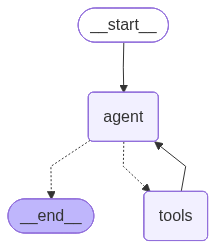

In [281]:
# =============================================================================
# VISUALIZE THE MEMORY-AWARE GRAPH
# =============================================================================

app_with_memory

In [282]:
# =============================================================================
# EXECUTION FUNCTION WITH MEMORY
# =============================================================================

def run_agent_with_memory(thread_id: str, user_id: str, user_input: str):
    """
    Execute the memory-aware agent.
    
    Args:
        thread_id: Unique conversation thread ID (short-term memory)
        user_id: User identifier for memory scoping (long-term memory)
        user_input: User's message
    """
    # Config with both thread_id and langgraph_user_id
    # IMPORTANT: langgraph_user_id must match the namespace pattern {langgraph_user_id}
    config = {
        "configurable": {
            "thread_id": thread_id,
            "langgraph_user_id": user_id,  # Required for memory namespace
        }
    }
    
    print(f"\n{'='*60}")
    print(f"Thread: {thread_id} | User: {user_id}")
    print(f"Input: {user_input}")
    print(f"{'='*60}\n")
    
    # Stream the response
    for step in app_with_memory.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config,
        stream_mode="values",
    ):
        msg = step["messages"][-1]
        if hasattr(msg, 'pretty_print'):
            msg.pretty_print()
        else:
            print(msg)

## Test 1: Save User Information to Memory

In this test, the user introduces themselves. The agent should:
1. Recognize this is personal information
2. Use `manage_memory` tool to save it
3. Acknowledge that it saved the information

In [283]:
# =============================================================================
# TEST 1: User introduces themselves - Agent should save to memory
# =============================================================================

run_agent_with_memory(
    thread_id="session-00202",
    user_id="user-124",
    user_input="Hi! I'm a senior DBA focusing on disaster recovery and backup strategies. Please remember this about me."
)


Thread: session-00202 | User: user-124
Input: Hi! I'm a senior DBA focusing on disaster recovery and backup strategies. Please remember this about me.

================================ Human Message =================================

Hi! I'm a senior DBA focusing on disaster recovery and backup strategies. Please remember this about me.


================================== Ai Message ==================================
Tool Calls:
  manage_memory (toolu_bdrk_01J2cTEEKKzDL6ULzppSACiB)
 Call ID: toolu_bdrk_01J2cTEEKKzDL6ULzppSACiB
  Args:
    action: create
    content: User is a senior DBA focusing on disaster recovery and backup strategies
================================= Tool Message =================================

created memory 2ce3ef71-61dd-4b64-aba1-ce45ee30fcbe
================================== Ai Message ==================================

Hello! Great to meet you! I've saved that you're a senior DBA with a focus on disaster recovery and backup strategies. 

I'm here to help you with any MongoDB-related questions, especially around topics like:
- Backup and restore procedures
- Disaster recovery planning
- High availability configurations
- Point-in-time recovery
- Backup strategies (mongodump, filesystem snapshots, MongoDB Atlas backups, etc.)
- Replication and failover scenarios

Feel free to ask me anythin

In [284]:
# =============================================================================
# VERIFY: Check if memory was saved to MongoDB
# =============================================================================

time.sleep(2)  # Brief pause for write to complete

print("=== Checking MongoDB for saved memories ===")
print(f"\nCollection: {MEMORY_DB_NAME}.{MEMORY_COLLECTION_NAME}")

# Query memories for user-123
user_memories = list(memory_collection.find({}))
print(f"\nTotal documents in collection: {len(user_memories)}")

for doc in user_memories:
    print(f"\n--- Memory Document ---")
    print(f"Namespace: {doc.get('namespace', 'N/A')}")
    print(f"Key: {doc.get('key', 'N/A')}")
    print(f"Value: {doc.get('value', 'N/A')}")

=== Checking MongoDB for saved memories ===

Collection: mongodb_genai_devday_agents.memories

Total documents in collection: 1

--- Memory Document ---
Namespace: ['memories', 'user-124']
Key: 2ce3ef71-61dd-4b64-aba1-ce45ee30fcbe
Value: {'content': 'User is a senior DBA focusing on disaster recovery and backup strategies'}


## Test 2: New Conversation Thread Recalls Memory

In this test, we start a NEW conversation thread but with the SAME user.
The agent should:
1. Search for existing memories about this user
2. Find the previously saved information
3. Use that context to personalize the response

In [285]:
# =============================================================================
# TEST 2: New thread, same user - Agent should recall memory
# =============================================================================

run_agent_with_memory(
    thread_id="session-00222",  # NEW thread
    user_id="user-124",        # SAME user
    user_input="What do you remember about me? And can you give me backup advice based on my role?"
)


Thread: session-00222 | User: user-124
Input: What do you remember about me? And can you give me backup advice based on my role?

================================ Human Message =================================

What do you remember about me? And can you give me backup advice based on my role?
================================== Ai Message ==================================
Tool Calls:
  search_memory (toolu_bdrk_01Ru9fweeNYbJFaZeiZwjPHJ)
 Call ID: toolu_bdrk_01Ru9fweeNYbJFaZeiZwjPHJ
  Args:
    query: user role job expertise preferences
================================= Tool Message =================================

[{"namespace":["memories","user-124"],"key":"2ce3ef71-61dd-4b64-aba1-ce45ee30fcbe","value":{"content":"User is a senior DBA focusing on disaster recovery and backup strategies"},"created_at":"2025-12-12T02:16:00.321000","updated_at":"2025-12-12T02:16:00.321000","score":0.6648042798042297}]
================================== Ai Message ==================================

G

## Test 3: Technical Question with User Context

Ask a technical question. The agent should:
1. Recall that the user is a DBA focused on disaster recovery
2. Tailor the response to their expertise level
3. Focus on backup/recovery aspects

In [286]:
# =============================================================================
# TEST 3: Technical question - Agent should use memory context
# =============================================================================

run_agent_with_memory(
    thread_id="session-00303",
    user_id="user-124",
    user_input="What are the best practices for MongoDB backups?"
)


Thread: session-00303 | User: user-124
Input: What are the best practices for MongoDB backups?

================================ Human Message =================================

What are the best practices for MongoDB backups?
================================== Ai Message ==================================

I'll help you find information about MongoDB backup best practices. Let me search for that information.
Tool Calls:
  search_memory (toolu_bdrk_01E2Q6RzfCpW3wY4uh8PnAFZ)
 Call ID: toolu_bdrk_01E2Q6RzfCpW3wY4uh8PnAFZ
  Args:
    query: user role expertise preferences
  get_information_for_question_answering (toolu_bdrk_016AoxN8ppNn8gk7KWruzSPm)
 Call ID: toolu_bdrk_016AoxN8ppNn8gk7KWruzSPm
  Args:
    user_query: MongoDB backup best practices
================================= Tool Message =================================

# Backup and Restore Sharded Clusters

The following tutorials describe backup and restoration for sharded clusters:

To use `mongodump` and `mongorestore` as a b

## Test 4: Different User (Memory Isolation)

Test with a different user to verify memory isolation.
This user should NOT see user-123's memories.

In [287]:
# =============================================================================
# TEST 4: Different user - Should NOT have user-123's memories
# =============================================================================

run_agent_with_memory(
    thread_id="session-00404",
    user_id="user-456",  # DIFFERENT user
    user_input="What do you know about me? I'm a cloud architect interested in MongoDB Atlas scaling."
)


Thread: session-00404 | User: user-456
Input: What do you know about me? I'm a cloud architect interested in MongoDB Atlas scaling.

================================ Human Message =================================

What do you know about me? I'm a cloud architect interested in MongoDB Atlas scaling.
================================== Ai Message ==================================
Tool Calls:
  search_memory (toolu_bdrk_01BVzhPZ8PX1zEtn5ZiAwh6p)
 Call ID: toolu_bdrk_01BVzhPZ8PX1zEtn5ZiAwh6p
  Args:
    query: cloud architect MongoDB Atlas scaling
================================= Tool Message =================================

[]
================================== Ai Message ==================================

I don't have any previous information about you in my memory. Thank you for sharing that with me! Let me save this information so I can better assist you in future conversations.
Tool Calls:
  manage_memory (toolu_bdrk_01Lk5BdGpNE71a59Q1au2GH2)
 Call ID: toolu_bdrk_01Lk5BdGpNE71a5

In [288]:
# =============================================================================
# VIEW ALL STORED MEMORIES
# =============================================================================

time.sleep(2)

print("=" * 60)
print("ALL STORED MEMORIES IN MONGODB")
print("=" * 60)

all_memories = list(memory_collection.find({}))
print(f"\nTotal memories: {len(all_memories)}\n")

for i, doc in enumerate(all_memories, 1):
    print(f"--- Memory {i} ---")
    print(f"Namespace: {doc.get('namespace', 'N/A')}")
    print(f"Key: {doc.get('key', 'N/A')}")
    value = doc.get('value', {})
    if isinstance(value, dict):
        print(f"Content: {value.get('content', value)}")
    else:
        print(f"Value: {value}")
    print()

ALL STORED MEMORIES IN MONGODB

Total memories: 2

--- Memory 1 ---
Namespace: ['memories', 'user-124']
Key: 2ce3ef71-61dd-4b64-aba1-ce45ee30fcbe
Content: User is a senior DBA focusing on disaster recovery and backup strategies

--- Memory 2 ---
Namespace: ['memories', 'user-456']
Key: c20c6bf5-f6ab-41ef-9f20-89f412f9bf48
Content: User is a cloud architect interested in MongoDB Atlas scaling



In [304]:
# =============================================================================
# TEST: Verify Semantic Search vs Keyword Search
# =============================================================================

# Step 1: Insert a test memory directly
test_namespace = ("memories", "test-user-sem")

memory_store.put(
    test_namespace,
    key="test-memory-1",
    value={"content": "User is a database administrator who manages MongoDB clusters"}
)
memory_store.put(
    test_namespace,
    key="test-memory-2",
    value={"content": "User somewhat likes fast food"}
)

print("✅ Stored memory: 'User is a database administrator who manages MongoDB clusters'")
print("\n" + "="*60)

# Step 2: Search with EXACT words (should work with both keyword and semantic)
results_exact = list(memory_store.search(
    test_namespace,
    query="database administrator",
    limit=5
))
print(f"\n🔍 Search query: 'database administrator' (exact words)")
print(f"   Results found: {len(results_exact)}")
for r in results_exact:
    print(f"   - Score: {r.score:.4f} | Content: {r.value.get('content', r.value)[:50]}...")

# Step 3: Search with SEMANTICALLY SIMILAR words (only works with vector search)
results_semantic = list(memory_store.search(
    test_namespace,
    query="DBA who handles NoSQL databases",  # Different words, same meaning
    limit=5
))
print(f"\n🔍 Search query: 'DBA who handles NoSQL databases' (semantic similarity)")
print(f"   Results found: {len(results_semantic)}")
for r in results_semantic:
    print(f"   - Score: {r.score:.4f} | Content: {r.value.get('content', r.value)[:50]}...")

# Step 4: Search with UNRELATED query (should return low score or no results)
results_unrelated = list(memory_store.search(
    test_namespace,
    query="pizza delivery restaurants",
    limit=5
))
print(f"\n🔍 Search query: 'pizza delivery restaurants' (unrelated)")
print(f"   Results found: {len(results_unrelated)}")
for r in results_unrelated:
    print(f"   - Score: {r.score:.4f} | Content: {r.value.get('content', r.value)[:50]}...")

# Step 5: Cleanup test data
#memory_store.delete(test_namespace, key="test-memory-1")
print("\n✅ Test memory cleaned up")

# =============================================================================
# INTERPRETATION:
# - If "DBA who handles NoSQL" returns results with score > 0.3, semantic search works!
# - If "pizza delivery" returns score < 0.2 (or no results), it's correctly filtering
# - If scores are all the same or "DBA" returns nothing, semantic search may not be configured
# =============================================================================

✅ Stored memory: 'User is a database administrator who manages MongoDB clusters'


🔍 Search query: 'database administrator' (exact words)
   Results found: 1
   - Score: 0.5954 | Content: User somewhat likes fast food...

🔍 Search query: 'DBA who handles NoSQL databases' (semantic similarity)
   Results found: 1
   - Score: 0.5894 | Content: User somewhat likes fast food...

🔍 Search query: 'pizza delivery restaurants' (unrelated)
   Results found: 2
   - Score: 0.6596 | Content: User somewhat likes fast food...
   - Score: 0.5531 | Content: User is a database administrator who manages Mongo...

✅ Test memory cleaned up


In [308]:
# =============================================================================
# TEST: Verify Semantic Search vs Keyword Search
# =============================================================================

# Step 1: Insert a test memory directly
test_namespace = ("memories", "test-user-sem")

memory_store.put(
    test_namespace,
    key="test-memory-7",
    value={"content": "User is a Rockstar Coder"}
)

print("✅ Stored memory: 'User is a database administrator who manages MongoDB clusters'")
print("\n" + "="*60)

# Step 2: Search with EXACT words (should work with both keyword and semantic)
results_exact = list(memory_store.search(
    test_namespace,
    query="database administrator",
    limit=5
))
print(f"\n🔍 Search query: 'database administrator' (exact words)")
print(f"   Results found: {len(results_exact)}")
for r in results_exact:
    print(f"   - Score: {r.score:.4f} | Content: {r.value.get('content', r.value)[:50]}...")

# Step 3: Search with SEMANTICALLY SIMILAR words (only works with vector search)
results_semantic = list(memory_store.search(
    test_namespace,
    query="DBA who handles NoSQL databases",  # Different words, same meaning
    limit=5
))
print(f"\n🔍 Search query: 'DBA who handles NoSQL databases' (semantic similarity)")
print(f"   Results found: {len(results_semantic)}")
for r in results_semantic:
    print(f"   - Score: {r.score:.4f} | Content: {r.value.get('content', r.value)[:50]}...")

# Step 4: Search with UNRELATED query (should return low score or no results)
results_unrelated = list(memory_store.search(
    test_namespace,
    query="pizza delivery restaurants",
    limit=5
))
print(f"\n🔍 Search query: 'pizza delivery restaurants' (unrelated)")
print(f"   Results found: {len(results_unrelated)}")
for r in results_unrelated:
    print(f"   - Score: {r.score:.4f} | Content: {r.value.get('content', r.value)[:50]}...")

# Step 5: Cleanup test data
#memory_store.delete(test_namespace, key="test-memory-1")
print("\n✅ Test memory cleaned up")

# =============================================================================
# INTERPRETATION:
# - If "DBA who handles NoSQL" returns results with score > 0.3, semantic search works!
# - If "pizza delivery" returns score < 0.2 (or no results), it's correctly filtering
# - If scores are all the same or "DBA" returns nothing, semantic search may not be configured
# =============================================================================

✅ Stored memory: 'User is a database administrator who manages MongoDB clusters'


🔍 Search query: 'database administrator' (exact words)
   Results found: 2
   - Score: 0.7504 | Content: User is a database administrator who manages Mongo...
   - Score: 0.5954 | Content: User somewhat likes fast food...

🔍 Search query: 'DBA who handles NoSQL databases' (semantic similarity)
   Results found: 2
   - Score: 0.7281 | Content: User is a database administrator who manages Mongo...
   - Score: 0.5894 | Content: User somewhat likes fast food...

🔍 Search query: 'pizza delivery restaurants' (unrelated)
   Results found: 2
   - Score: 0.6596 | Content: User somewhat likes fast food...
   - Score: 0.5531 | Content: User is a database administrator who manages Mongo...

✅ Test memory cleaned up
